####Imports

In [1]:
!pip install mvlearn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.0.0 requires matplotlib>=3.7.1, but you have matplotlib 3.3.4 which is incompatible.
mizani 0.9.3 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
plotnine 0.12.4 requires matplotlib>=3.6.0, but you have matplotlib 3.3.4 which is incompatible.


In [2]:
!pip install keras -q

In [88]:
import warnings
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from google.colab import drive
from scipy.stats import skew, mode
from itertools import combinations
from scipy import stats

from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.semi_supervised import LabelPropagation, SelfTrainingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from mvlearn.semi_supervised import CTClassifier

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
np.random.seed(203)

In [4]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


#### Data

This dataset is about the direct phone call marketing campaigns, which aim to promote term deposits among existing customers, by a Portuguese banking institution from May 2008 to November 2010.

In [7]:
# loading csv into dataframe
df = pd.read_csv("/content/gdrive/MyDrive/MCS/CSI5155/Project/archive/bank_cleaned.csv", sep=",")
df.drop(df.columns[[0, -2]], axis=1, inplace=True)
df.rename(columns={df.columns[-1]: 'y'}, inplace=True)
df

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,4.35,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,5,may,2.52,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1.27,1,-1,0,unknown,0
3,35,management,married,tertiary,no,231,yes,no,5,may,2.32,1,-1,0,unknown,0
4,28,management,single,tertiary,no,447,yes,yes,5,may,3.62,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40836,25,technician,single,secondary,no,505,no,yes,17,nov,6.43,2,-1,0,unknown,1
40837,51,technician,married,tertiary,no,825,no,no,17,nov,16.28,3,-1,0,unknown,1
40838,71,retired,divorced,primary,no,1729,no,no,17,nov,7.60,2,-1,0,unknown,1
40839,72,retired,married,secondary,no,5715,no,no,17,nov,18.78,5,184,3,success,1


1 - age (numeric)

2 - job: type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")

3 - marital: marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

other attributes:

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):

17 - y: has the client subscribed a term deposit? (binary: "yes","no")

In [8]:
df.shape

(40841, 16)

#### Data Cleaning

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40841 entries, 0 to 40840
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        40841 non-null  int64  
 1   job        40841 non-null  object 
 2   marital    40841 non-null  object 
 3   education  40841 non-null  object 
 4   default    40841 non-null  object 
 5   balance    40841 non-null  int64  
 6   housing    40841 non-null  object 
 7   loan       40841 non-null  object 
 8   day        40841 non-null  int64  
 9   month      40841 non-null  object 
 10  duration   40841 non-null  float64
 11  campaign   40841 non-null  int64  
 12  pdays      40841 non-null  int64  
 13  previous   40841 non-null  int64  
 14  poutcome   40841 non-null  object 
 15  y          40841 non-null  int64  
dtypes: float64(1), int64(7), object(8)
memory usage: 5.0+ MB


In [10]:
# checking for the categorical columns and their unique values
for column in df.select_dtypes(include='object').columns:
  print(f"\n{column}: \n----------------------------- \n{df[column].value_counts()}\n")


job: 
----------------------------- 
job
blue-collar      8805
management       8565
technician       6954
admin.           4705
services         3801
retired          2020
self-employed    1443
entrepreneur     1340
unemployed       1212
housemaid        1149
student           689
other             158
Name: count, dtype: int64


marital: 
----------------------------- 
marital
married     24641
single      11443
divorced     4757
Name: count, dtype: int64


education: 
----------------------------- 
education
secondary    21933
tertiary     12380
primary       6528
Name: count, dtype: int64


default: 
----------------------------- 
default
no     40078
yes      763
Name: count, dtype: int64


housing: 
----------------------------- 
housing
yes    22820
no     18021
Name: count, dtype: int64


loan: 
----------------------------- 
loan
no     34042
yes     6799
Name: count, dtype: int64


month: 
----------------------------- 
month
may    12496
jul     6520
aug     5877
jun     48

In [11]:
# checking for null values
print("Total null values in the data: ", df.isnull().sum().sum(), "\n")

Total null values in the data:  0 



In [12]:
# checking for NaNs in the dataset
df.isna().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [13]:
# checking for any duplicate instances
print("Number of duplicated rows = ", len(df[df.duplicated()]))
df[df.duplicated()]

Number of duplicated rows =  0


,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y


In [14]:
# checking if there's any column that has no impact on the output
df.nunique()

age            75
job            12
marital         3
education       3
default         2
balance      6350
housing         2
loan            2
day            31
month          12
duration     1539
campaign       47
pdays         510
previous       36
poutcome        3
y               2
dtype: int64

No null values, no NaNs, no duplicate rows found.

#### Exploratory Data Analysis

In [15]:
def count_y(df):
  cnt_df = df['y'].value_counts().to_frame().reset_index()
  cnt_df['percentage (%)'] = cnt_df['y'].apply(lambda x : round(100*float(x) / len(df), 2))
  cnt_df = cnt_df.rename(columns = {"index" : "subscribe?", 'y' : 'count'})
  return cnt_df

In [16]:
count_y(df)

,count,count,percentage (%)
0,0,36202,0.0
1,1,4639,0.0


In [17]:
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_cols = [col for col in df.columns if col not in num_cols and col != 'y']

<Axes: xlabel='y', ylabel='count'>

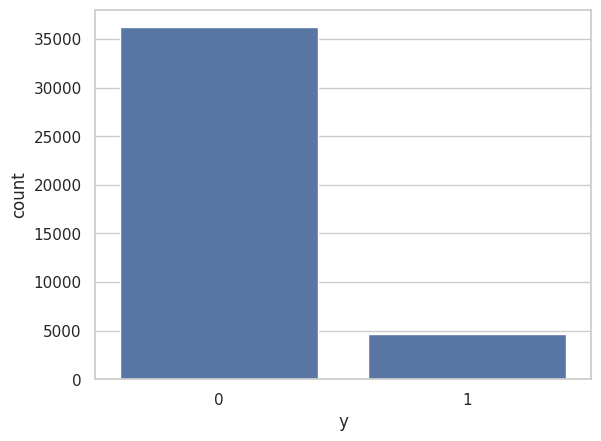

In [18]:
# class imbalance
sns.countplot(x='y', data=df)

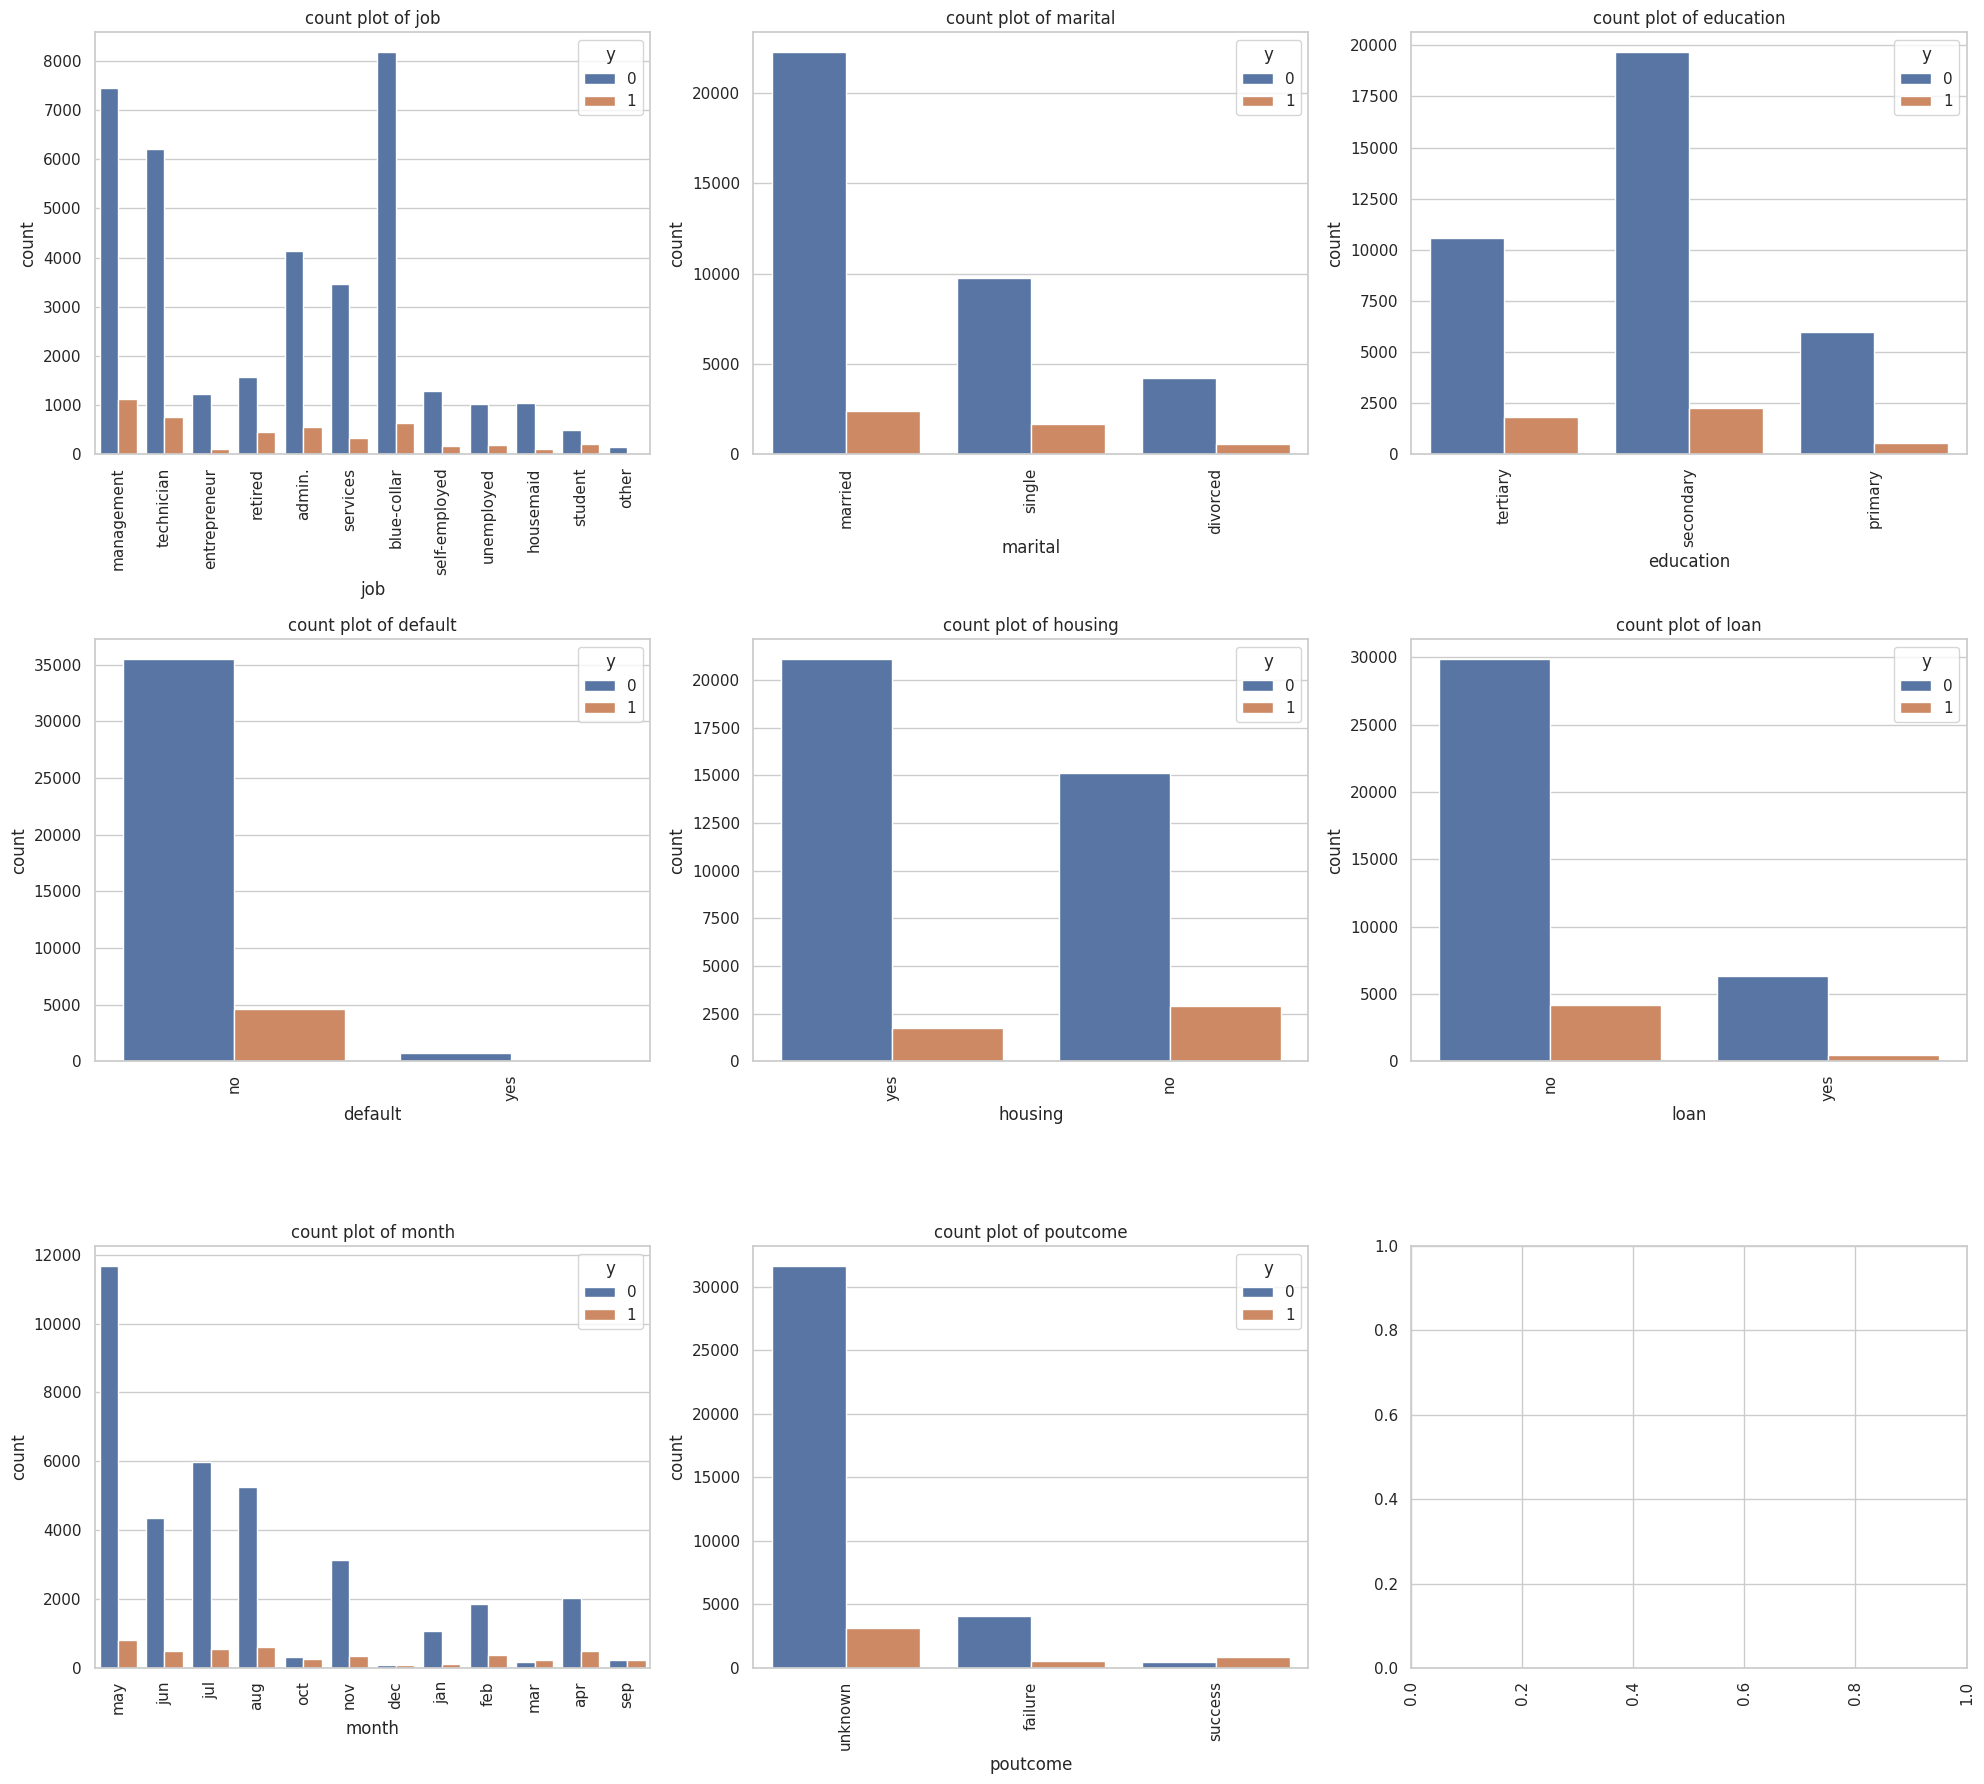

In [19]:
# count plots of categorical columns with y="Yes" and "No"
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue='y', data=df, ax=axes[i])
    axes[i].set_title(f'count plot of {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

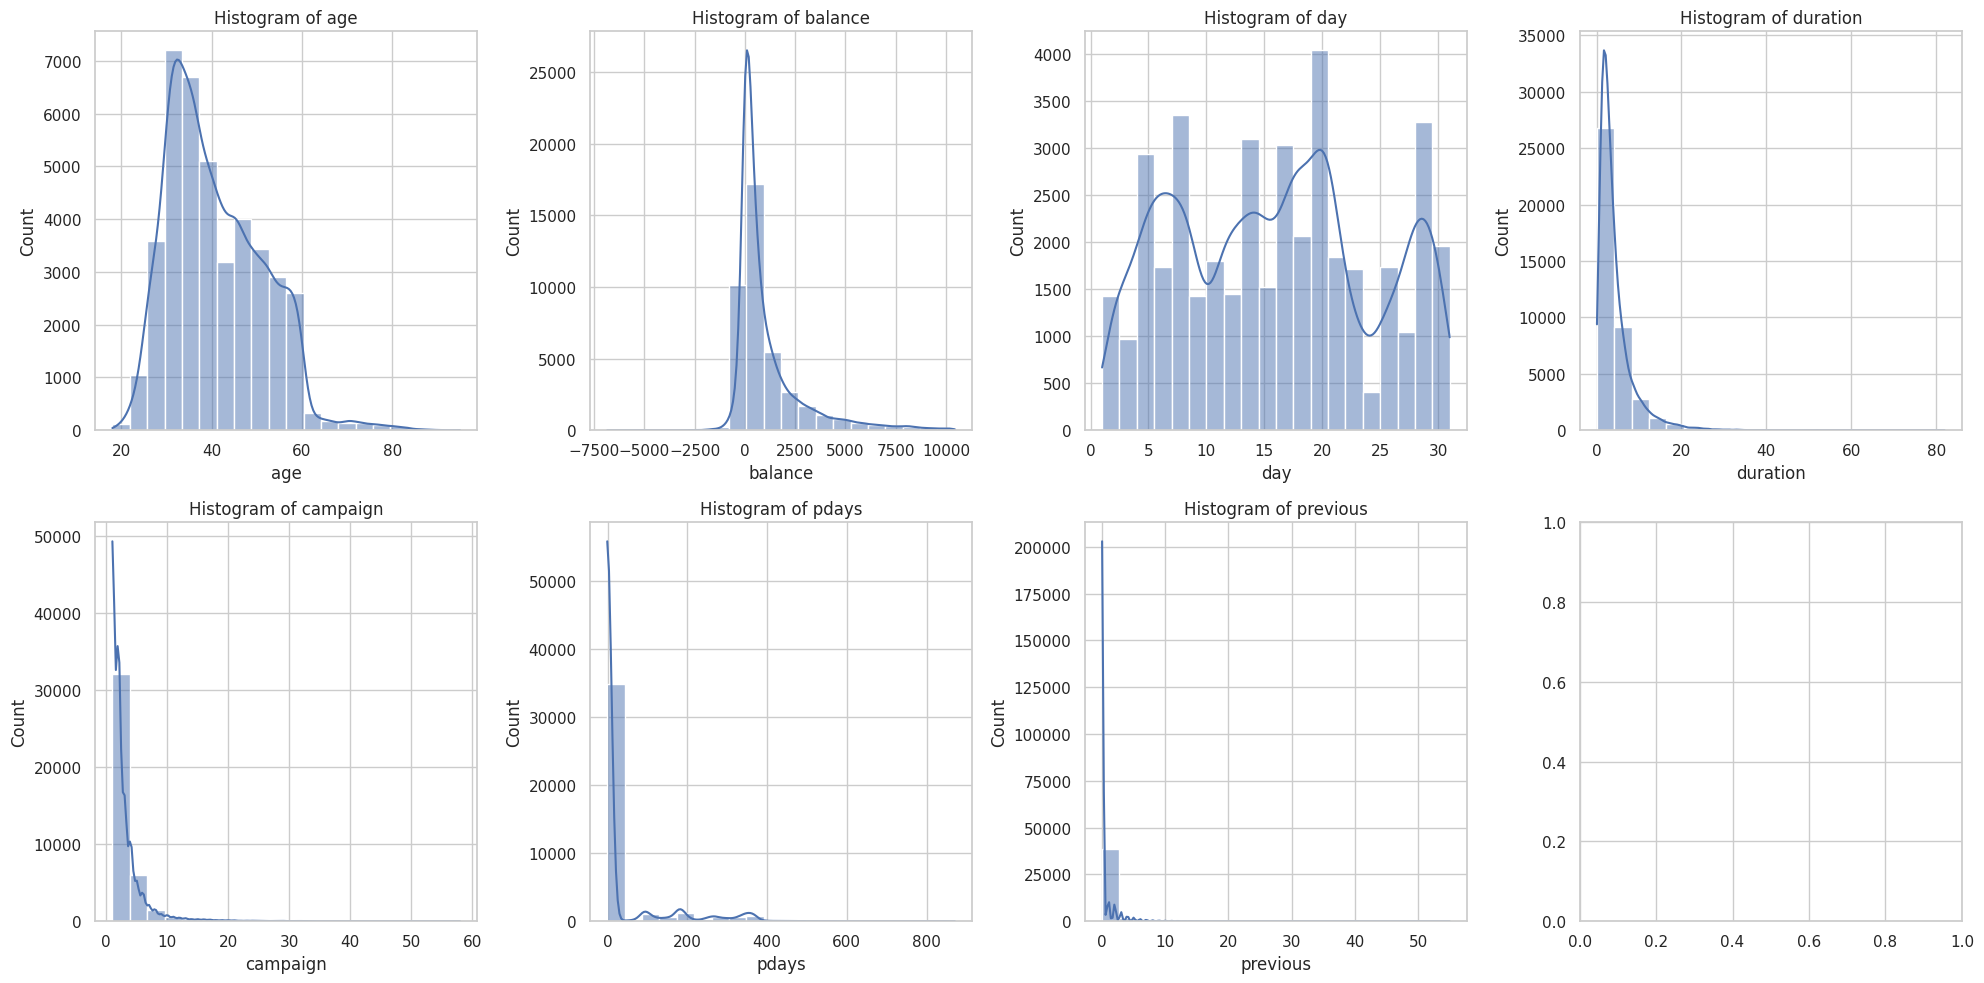

In [20]:
# histograms of numerical columns
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
  sns.histplot(x=col, data=df, ax=axes[i], bins=20, kde=True)
  axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40841.0,40.790676,10.475473,18.0,33.00,39.0,48.0,95.00
balance,40841.0,1073.981807,1712.556186,-6847.0,64.00,421.0,1333.0,10443.00
day,40841.0,15.863666,8.313608,1.0,8.00,16.0,21.0,31.00
duration,40841.0,4.308949,4.305823,0.1,1.73,3.0,5.3,81.97
campaign,40841.0,2.774149,3.104177,1.0,1.00,2.0,3.0,58.00
pdays,40841.0,32.248304,90.738402,-1.0,-1.00,-1.0,-1.0,871.00
previous,40841.0,0.436791,1.572342,0.0,0.00,0.0,0.0,55.00
y,40841.0,0.113587,0.317313,0.0,0.00,0.0,0.0,1.00


<Axes: >

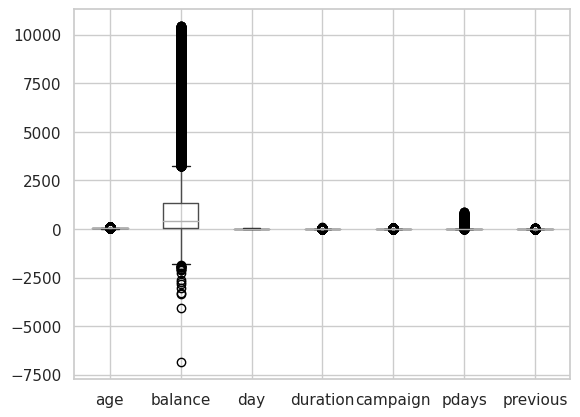

In [22]:
df[num_cols].boxplot()

age            Axes(0.125,0.653529;0.227941x0.226471)
balance     Axes(0.398529,0.653529;0.227941x0.226471)
day         Axes(0.672059,0.653529;0.227941x0.226471)
duration       Axes(0.125,0.381765;0.227941x0.226471)
campaign    Axes(0.398529,0.381765;0.227941x0.226471)
pdays       Axes(0.672059,0.381765;0.227941x0.226471)
previous           Axes(0.125,0.11;0.227941x0.226471)
dtype: object

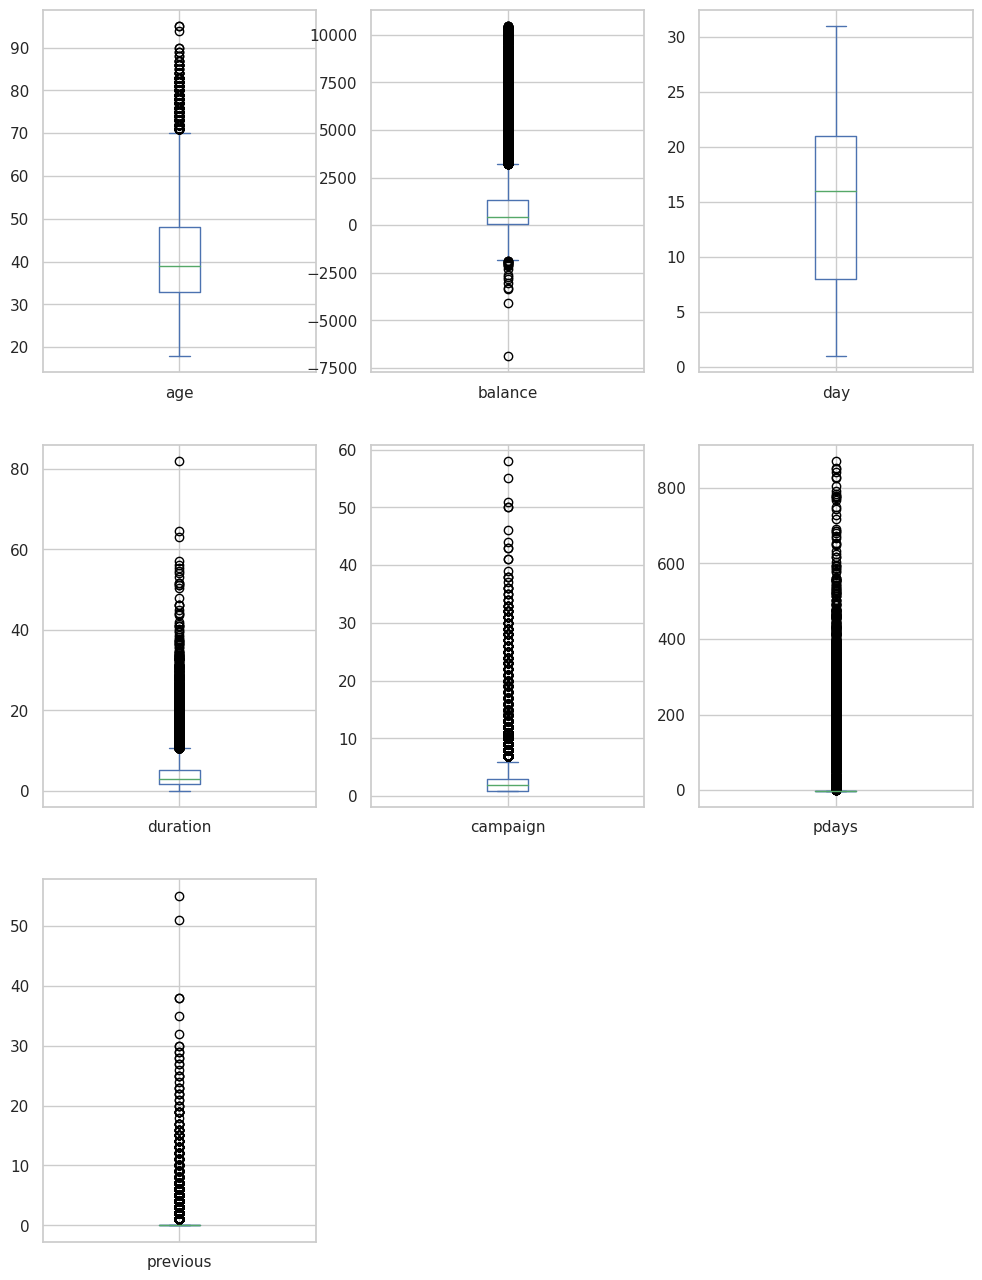

In [23]:
df[num_cols].plot(kind="box", subplots=True, figsize=(12, 16), layout=(3, 3))

<Axes: xlabel='duration', ylabel='campaign'>

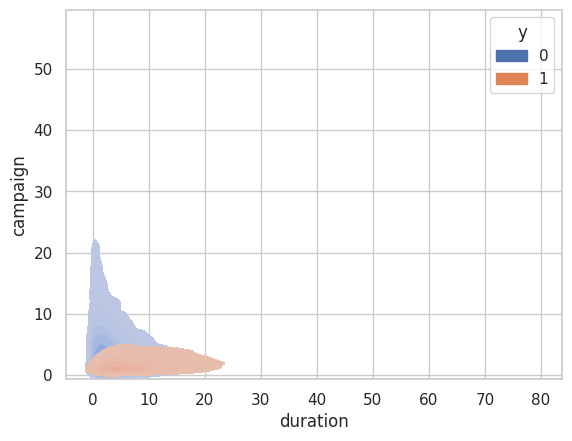

In [24]:
# number of calls <= 5 -> more chances of subscription
sns.kdeplot(x='duration', y='campaign', data=df, fill=True, hue='y')

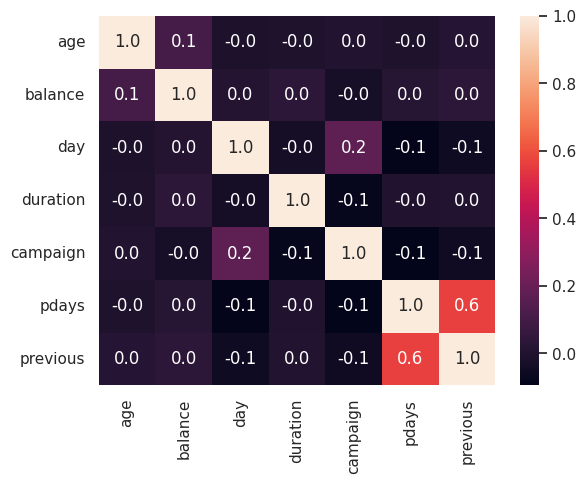

In [25]:
# heatmap of correlation values for numerical columns
sns.heatmap(df[num_cols].corr(), fmt=".1f", annot=True)
plt.show()

#### Data Preprocessing

In [26]:
def iq_outlier_detection(q1, q3, column, df):
  Q1 = df[column].quantile(q1)
  Q3 = df[column].quantile(q3)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
  df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df

In [27]:
# df = iq_outlier_detection(0.1, 0.9, 'balance', df)
# df = iq_outlier_detection(0.1, 0.9, 'campaign', df)
# df = iq_outlier_detection(0.1, 0.9, 'duration', df)
# df = iq_outlier_detection(0.1, 0.9, 'previous', df)
# df = iq_outlier_detection(0.1, 0.9, 'age', df)

In [28]:
# Calculate the count of 'unknown' and 'other' in the 'poutcome' column
unknown_count = (df['poutcome'] == 'unknown').sum()
other_count = (df['poutcome'] == 'other').sum()

# Calculate the percentage of 'unknown' and 'other'
percentage_unknown = (unknown_count / len(df)) * 100
percentage_other = (other_count / len(df)) * 100

print("Percentage of 'unknown' in poutcome:", percentage_unknown)
print("Percentage of 'other' in poutcome:", percentage_other)

Percentage of 'unknown' in poutcome: 85.21338850664773
Percentage of 'other' in poutcome: 0.0


Since, 'unknown' and 'other' constitute around 85% of the whole 'poutcome' column, ML model ain't going to learn much. So, better to drop it.

In [29]:
# Drop the 'poutcome' column from the dataset
df = df.drop(columns=['poutcome'])

Since most of the categorical variables are nominal, hence we decided to go agead with the one-hot encoding

In [30]:
# Perform one-hot encoding on the categorical variables
df = pd.get_dummies(df, columns=['job', 'marital', 'default', 'housing', 'loan'])

In [31]:
label_encoder = LabelEncoder()

# Apply label encoding directly to the 'y' column in the original dataframe
df['y'] = label_encoder.fit_transform(df['y'])
df['month'] = label_encoder.fit_transform(df['month'])
df['education'] = label_encoder.fit_transform(df['education'])

In [33]:
# Select boolean columns
bool_columns = df.select_dtypes(include=bool).columns

# Convert boolean columns to 0s and 1s
df[bool_columns] = df[bool_columns].astype(int)

In [34]:
df.head()

,age,education,balance,day,month,duration,campaign,pdays,previous,y,...,job_unemployed,marital_divorced,marital_married,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
0,58,2,2143,5,8,4.35,1,-1,0,0,...,0,0,1,0,1,0,0,1,1,0
1,44,1,29,5,8,2.52,1,-1,0,0,...,0,0,0,1,1,0,0,1,1,0
2,33,1,2,5,8,1.27,1,-1,0,0,...,0,0,1,0,1,0,0,1,0,1
3,35,2,231,5,8,2.32,1,-1,0,0,...,0,0,1,0,1,0,0,1,1,0
4,28,2,447,5,8,3.62,1,-1,0,0,...,0,0,0,1,1,0,0,1,0,1


#### Feature Engineering

In [43]:
# checking skewness of numerical cols
df[num_cols].skew()

age         0.680535
balance     2.434861
day         0.086254
duration    3.207748
campaign    4.780104
pdays       2.983790
previous    8.604262
dtype: float64

previous, pdays are still highly right skewed

In [71]:
# train-test split (75-25)
X = df.drop(columns=['y'])
y = df['y']
X_train_unsampled, X_test, y_train_unsampled, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [72]:
# normalise data
scaler = RobustScaler()
X_train_unsampled[num_cols] = scaler.fit_transform(X_train_unsampled[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [73]:
X_train_unsampled.head()

,age,education,balance,day,month,duration,campaign,pdays,previous,job_admin.,...,job_unemployed,marital_divorced,marital_married,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
20127,-0.400000,2,-0.226593,0.153846,1,-0.467967,0.0,0.0,0.0,0,...,0,0,0,1,1,0,1,0,1,0
32866,0.266667,1,-0.330448,-0.615385,8,-0.802228,1.5,0.0,0.0,0,...,0,0,1,0,1,0,0,1,0,1
39372,-0.133333,1,0.815106,0.461538,7,0.760446,-0.5,327.0,1.0,0,...,0,0,1,0,1,0,1,0,1,0
27626,-0.466667,2,0.221086,-1.000000,3,1.434540,0.0,272.0,2.0,0,...,0,0,0,1,1,0,0,1,1,0
15481,-0.800000,2,0.145555,0.538462,5,-0.264624,0.5,0.0,0.0,0,...,0,0,1,0,1,0,0,1,1,0


In [74]:
X_test.head()

,age,education,balance,day,month,duration,campaign,pdays,previous,job_admin.,...,job_unemployed,marital_divorced,marital_married,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
39077,1.400000,1,1.125885,-0.461538,3,0.250696,-0.5,184.0,1.0,0,...,0,0,1,0,1,0,1,0,1,0
2769,1.133333,1,0.361133,-0.153846,8,0.208914,0.0,0.0,0.0,0,...,0,0,1,0,1,0,0,1,1,0
39102,0.600000,1,-0.084186,-0.384615,3,0.423398,-0.5,0.0,0.0,0,...,0,0,0,1,1,0,1,0,1,0
37456,-0.333333,2,0.361920,-0.230769,1,-0.208914,-0.5,114.0,5.0,1,...,0,0,1,0,1,0,1,0,1,0
9666,-0.066667,0,-0.332022,-0.307692,6,-0.607242,0.0,0.0,0.0,0,...,0,1,0,0,1,0,1,0,1,0


In [ ]:
def calculate_distribution(y, dataset_name):
    # Calculate the count of each class
    class_counts = y.value_counts()
    total_count = len(y)
    print(f"\nDistribution in {dataset_name}:")
    for value in class_counts.index:
        percentage = (class_counts[value] / total_count) * 100
        print(f"Percentage of '{value}': {percentage:.2f}%")

In [ ]:
calculate_distribution(y_train_unsampled, 'training')
calculate_distribution(y_test, 'testing')


Distribution in training:
Percentage of '0': 88.64%
Percentage of '1': 11.36%

Distribution in testing:
Percentage of '0': 88.64%
Percentage of '1': 11.36%


#### Sampling

first oversample the minority class to have 20 percent the number of examples of the majority class, then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class.

Oversampling followed by undersampling, also known as SMOTE-ENN (Synthetic Minority Over-sampling Technique - Edited Nearest Neighbors), is a strategy used to address imbalanced datasets. It involves generating synthetic samples for the minority class through oversampling and then removing noisy and borderline samples using undersampling techniques.

In [50]:
# Apply SMOTE only to the training
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)

pipeline = Pipeline(steps=[('o', over), ('u', under)])

# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train_unsampled, y_train_unsampled)

In [51]:
calculate_distribution(y_train, 'after sampling')


Distribution in after sampling:
Percentage of '0': 66.67%
Percentage of '1': 33.33%


In [52]:
X_train[num_cols].skew()

age         0.795858
balance     2.334154
day         0.120677
duration    2.609057
campaign    5.231725
pdays       2.750084
previous    7.455818
dtype: float64

In [53]:
X_train.head()

,age,education,balance,day,month,duration,campaign,pdays,previous,job_admin.,...,job_unemployed,marital_divorced,marital_married,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
0,-0.533333,2,-0.229740,-0.846154,8,-0.116992,-0.5,0.0,0.0,0,...,0,0,0,1,1,0,0,1,1,0
1,-0.133333,1,0.003147,-0.230769,8,0.662953,0.5,346.0,3.0,0,...,0,0,1,0,1,0,0,1,1,0
2,1.400000,1,-0.332022,-0.846154,1,0.103064,-0.5,0.0,0.0,1,...,0,0,1,0,1,0,1,0,1,0
3,-0.466667,1,-0.505114,0.692308,5,-0.264624,0.0,0.0,0.0,0,...,0,0,1,0,0,1,0,1,0,1
4,-0.600000,1,-0.284815,0.692308,5,-0.551532,0.0,0.0,0.0,1,...,0,0,1,0,1,0,1,0,0,1


#### Supervised ML (on fully labelled dataset)

In [57]:
def plot_confusion_matrix(y_test, y_pred):
    '''
      Plot confusion Matrix
    '''
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
    # Add labels
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def model_evaluation(y_test, y_pred):
    '''
      Compute recall, precision, accuracy, f1-score, and plot confusion matrix
    '''
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}\nAccuracy: {accuracy:.2f}\n")
    print("Classification Report:\n", classification_report(y_test, y_pred))

def param_tuning(model, param_grid, x_train, y_train, splits=10):
    '''
      Using GridSearch along with Stratified k-cross validation to do hyperparameter tuning
    '''
    cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    gs = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=make_scorer(recall_score))
    gs.fit(x_train, y_train)
    return gs.best_estimator_, gs.best_params_, gs.best_score_

def calculate_roc(model, x_test, y_test):
  '''
    Get predicted probabilities for the positive class and compute ROC curve and area under the curve (AUC)
  '''
  y_prob = model.predict_proba(x_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)
  return roc_auc, fpr, tpr

def plot_roc_curve(model, x_test, y_test):
    '''
      Plot ROC curve
    '''
    roc_auc, fpr, tpr = calculate_roc(model, x_test, y_test)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Precision: 0.45
Recall: 0.71
F1-score: 0.55
Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      9051
           1       0.45      0.71      0.55      1160

    accuracy                           0.87     10211
   macro avg       0.70      0.80      0.74     10211
weighted avg       0.90      0.87      0.88     10211



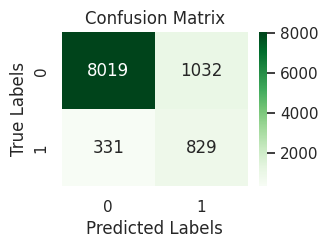

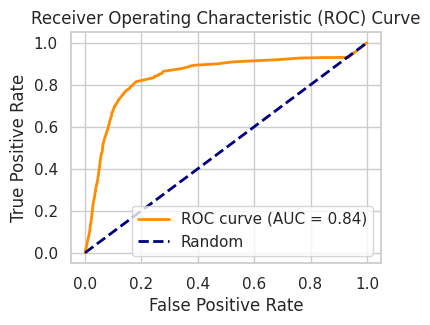

In [58]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
model_evaluation(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(dt, X_test, y_test)

Precision: 0.50
Recall: 0.72
F1-score: 0.59
Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      9051
           1       0.50      0.72      0.59      1160

    accuracy                           0.89     10211
   macro avg       0.73      0.81      0.76     10211
weighted avg       0.91      0.89      0.89     10211



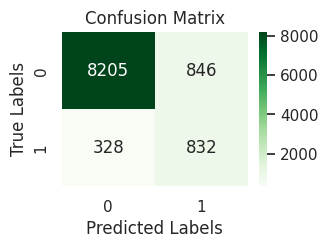

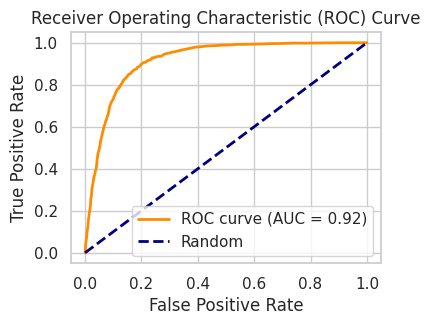

In [59]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model_evaluation(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(rf, X_test, y_test)

Precision: 0.41
Recall: 0.48
F1-score: 0.44
Accuracy: 0.86

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      9051
           1       0.41      0.48      0.44      1160

    accuracy                           0.86     10211
   macro avg       0.67      0.70      0.68     10211
weighted avg       0.87      0.86      0.87     10211



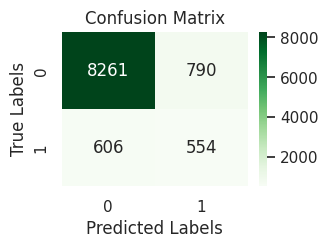

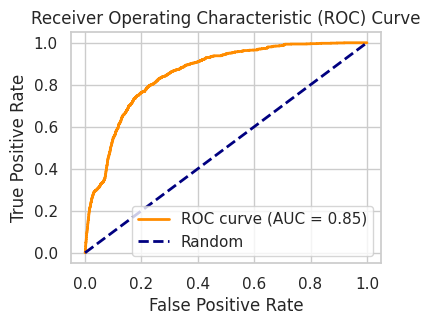

In [60]:
# SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
model_evaluation(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(svm, X_test, y_test)

Precision: 0.51
Recall: 0.72
F1-score: 0.60
Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      9051
           1       0.51      0.72      0.60      1160

    accuracy                           0.89     10211
   macro avg       0.74      0.82      0.77     10211
weighted avg       0.91      0.89      0.90     10211



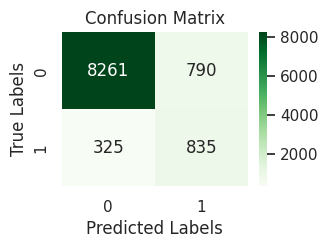

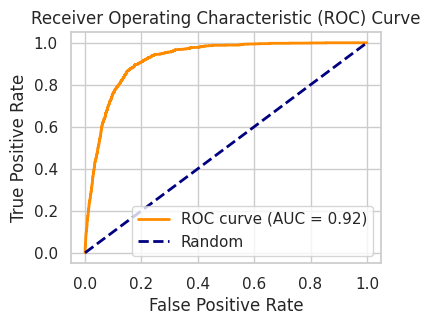

In [61]:
# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=1000)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
model_evaluation(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(gb, X_test, y_test)

Precision: 0.62
Recall: 0.35
F1-score: 0.45
Accuracy: 0.90

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      9051
           1       0.62      0.35      0.45      1160

    accuracy                           0.90     10211
   macro avg       0.77      0.66      0.70     10211
weighted avg       0.89      0.90      0.89     10211



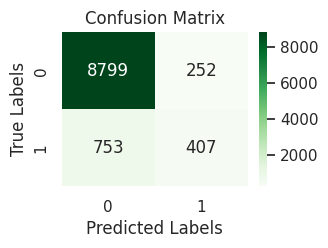

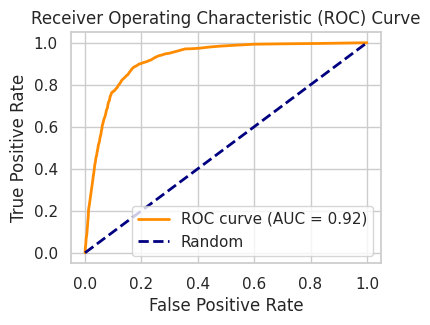

In [89]:
# Random Forest on imbalance (unsampled dataset)
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train_unsampled, y_train_unsampled)
y_pred = rf.predict(X_test)
model_evaluation(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(rf, X_test, y_test)

#### Semi-supervised learning

##### 1. self-training algorithm

In [68]:
def run_ss_evaluation(fun2, X_train, y_train, X_test, y_test, unlabelled_partition_samples=[0.5, 0.75, 0.9, 0.95, 0.99]):
  '''
    Self training on all different partitions of unlabelled instances
  '''
  for partition in unlabelled_partition_samples:
    start = time.time()
    print(f"Partition Sample = {partition}\n")
    num_samples = int(partition * len(X_train))

    # Split the data into labelled and unlabelled using stratified sampling
    X_label, X_unlabel, y_label, y_unlabel = train_test_split(X_train, y_train, test_size=num_samples, stratify=y_train, random_state=42)

    print("Labelled data instances: ", X_label.shape)
    print("Unlabelled data instances: ", X_unlabel.shape)

    # create the training dataset input
    X_train_mixed = np.concatenate((X_label, X_unlabel))
    # create "no label" for unlabeled y data
    nolabel = [-1 for _ in range(len(y_unlabel))]
    # recombine training dataset labels
    y_train_mixed = np.concatenate((y_label, nolabel))

    class_distribution = Counter(y_train_mixed)

    # Print the class distribution
    for class_label, count in class_distribution.items():
        print(f"Class {class_label}: {count} samples")

    # Call fun2
    fun2(X_train_mixed, y_train_mixed, X_test, y_test)
    end = time.time()
    print(f"\nRun time for self training (partition={partition}): {((end-start)/60)} min.")
    print("\n----------------------------------\n\n")

In [64]:
def evaluation(model, X_test, y_test, y_pred):
  model_evaluation(y_test, y_pred)
  plot_confusion_matrix(y_test, y_pred)
  plot_roc_curve(model, X_test, y_test)

In [65]:
# using SelfTrainingClassifier (scikit-learn)
def self_training_algo1(sup_model, xtrain, ytrain, xtest, ytest):
  model = SelfTrainingClassifier(sup_model, threshold=0.85)
  model.fit(xtrain, ytrain)
  # make predictions on hold out test set
  y_pred = model.predict(xtest)
  evaluation(model, xtest, ytest, y_pred)
  return y_pred

def self_training_algo2(sup_model, X_label, y_label, X_unlabel, y_unlabel, X_test, y_test):
  while True:
    sup_model.fit(X_label, y_label)
    X_unlabel.reset_index(drop=True, inplace=True)
    y_pred = sup_model.predict_proba(X_unlabel)
    indices = [idx for idx, x in enumerate(np.max(y_pred, axis=1)) if x > 0.9]
    if len(indices) == 0:
      break
    temp = X_unlabel.iloc[indices]
    X_unlabel.drop(indices, inplace=True)
    pred = pd.Series(sup_model.predict(temp))
    X_label = X_label.append(temp, ignore_index=True)
    y_label = y_label.append(pred, ignore_index=True)
  sup_model.fit(X_label, y_label)
  y_pred = sup_model.predict(X_test)
  evaluation(sup_model, X_test, y_test, y_pred)
  return y_pred

In [66]:
def make_self_training_model(X_train_mixed, y_train_mixed, X_test, y_test):
  sup_model = GradientBoostingClassifier(n_estimators=1000)
  st_pred = self_training_algo1(sup_model, X_train_mixed, y_train_mixed, X_test, y_test)

Partition Sample = 0.5

Labelled data instances:  (8145, 30)
Unlabelled data instances:  (8145, 30)
Class 0: 5430 samples
Class 1: 2715 samples
Class -1: 8145 samples
Precision: 0.50
Recall: 0.71
F1-score: 0.59
Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      9051
           1       0.50      0.71      0.59      1160

    accuracy                           0.89     10211
   macro avg       0.73      0.81      0.76     10211
weighted avg       0.91      0.89      0.90     10211



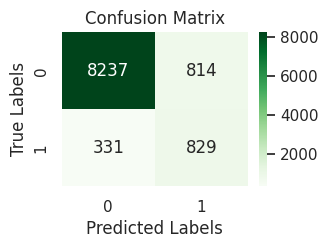

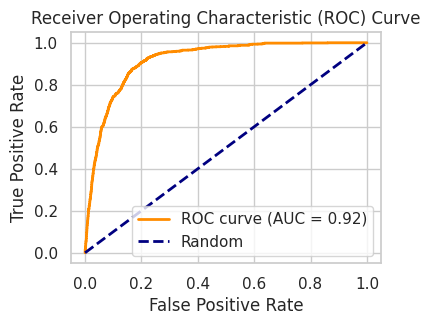


Run time for self training (partition=0.5): 5.646672348181407 min.

----------------------------------


Partition Sample = 0.75

Labelled data instances:  (4073, 30)
Unlabelled data instances:  (12217, 30)
Class 0: 2715 samples
Class 1: 1358 samples
Class -1: 12217 samples
Precision: 0.49
Recall: 0.71
F1-score: 0.58
Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      9051
           1       0.49      0.71      0.58      1160

    accuracy                           0.88     10211
   macro avg       0.73      0.81      0.76     10211
weighted avg       0.91      0.88      0.89     10211



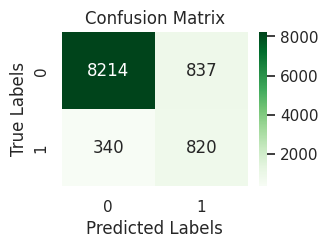

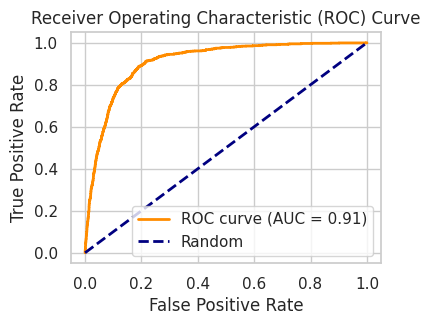


Run time for self training (partition=0.75): 5.462473074595134 min.

----------------------------------


Partition Sample = 0.9

Labelled data instances:  (1629, 30)
Unlabelled data instances:  (14661, 30)
Class 0: 1086 samples
Class 1: 543 samples
Class -1: 14661 samples
Precision: 0.46
Recall: 0.69
F1-score: 0.56
Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      9051
           1       0.46      0.69      0.56      1160

    accuracy                           0.87     10211
   macro avg       0.71      0.80      0.74     10211
weighted avg       0.90      0.87      0.88     10211



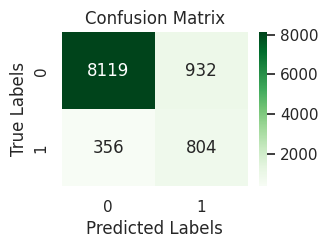

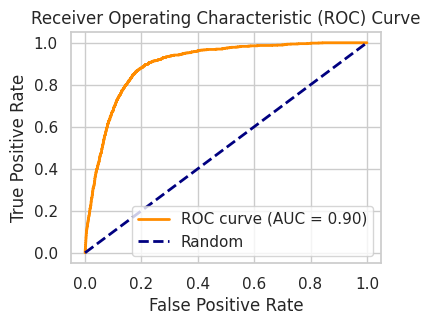


Run time for self training (partition=0.9): 5.356168075402578 min.

----------------------------------


Partition Sample = 0.95

Labelled data instances:  (815, 30)
Unlabelled data instances:  (15475, 30)
Class 0: 543 samples
Class 1: 272 samples
Class -1: 15475 samples
Precision: 0.43
Recall: 0.70
F1-score: 0.53
Accuracy: 0.86

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      9051
           1       0.43      0.70      0.53      1160

    accuracy                           0.86     10211
   macro avg       0.69      0.79      0.73     10211
weighted avg       0.90      0.86      0.87     10211



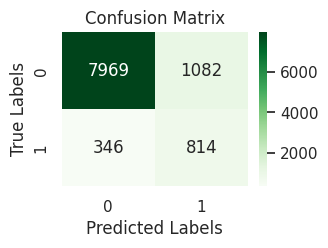

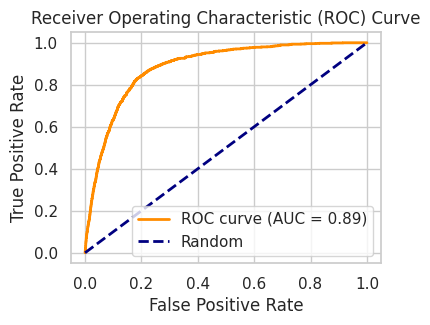


Run time for self training (partition=0.95): 5.444556991259257 min.

----------------------------------


Partition Sample = 0.99

Labelled data instances:  (163, 30)
Unlabelled data instances:  (16127, 30)
Class 0: 109 samples
Class 1: 54 samples
Class -1: 16127 samples
Precision: 0.42
Recall: 0.58
F1-score: 0.49
Accuracy: 0.86

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      9051
           1       0.42      0.58      0.49      1160

    accuracy                           0.86     10211
   macro avg       0.68      0.74      0.71     10211
weighted avg       0.88      0.86      0.87     10211



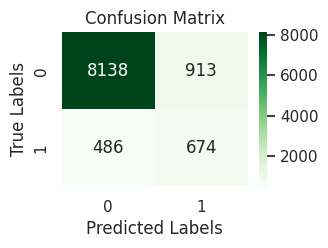

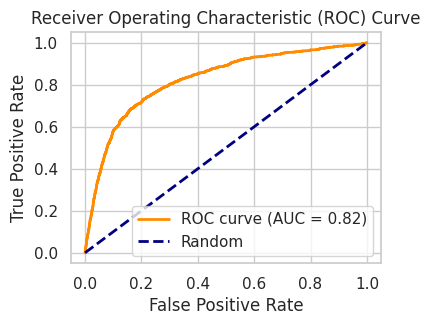


Run time for self training (partition=0.99): 5.539404575030009 min.

----------------------------------




In [69]:
run_ss_evaluation(make_self_training_model, X_train, y_train, X_test, y_test)

Partition Sample = 0.9

Labelled data instances:  (3063, 30)
Unlabelled data instances:  (27567, 30)
Class 0: 2715 samples
Class 1: 348 samples
Class -1: 27567 samples
Precision: 0.60
Recall: 0.36
F1-score: 0.45
Accuracy: 0.90

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      9051
           1       0.60      0.36      0.45      1160

    accuracy                           0.90     10211
   macro avg       0.76      0.67      0.70     10211
weighted avg       0.89      0.90      0.89     10211



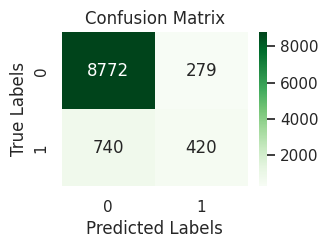

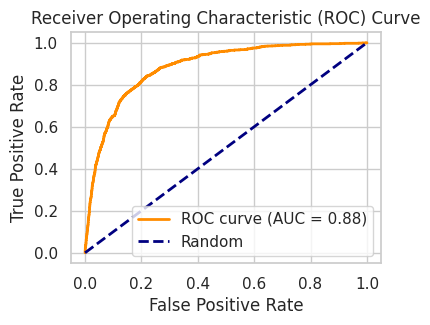


Run time for self training (partition=0.9): 10.654529142379761 min.

----------------------------------




In [70]:
# imbalanced dataset with 0.9 unlabelled partition
run_ss_evaluation(make_self_training_model, X_train_unsampled, y_train_unsampled, X_test, y_test, unlabelled_partition_samples=[0.9])

##### 2. co-training algorithm

In [ ]:
def plot_roc_curve_prob(y_true, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
def cotraining_evaluation(ss_fun, X_train, y_train, X_test, y_test, unlabelled_partition_samples=[0.5, 0.75, 0.9, 0.95, 0.99]):

  for partition in unlabelled_partition_samples:
    start = time.time()
    print(f"Partition Sample = {partition}\n")
    num_samples = int(partition * len(X_train))

    # Split the data into labelled and unlabelled using stratified sampling
    X_label, X_unlabel, y_label, y_unlabel = train_test_split(X_train, y_train, test_size=num_samples, stratify=y_train, random_state=42)

    print("Labelled data instances: ", X_label.shape)
    print("Unlabelled data instances: ", X_unlabel.shape)

    # create the training dataset input
    X_train_mixed = np.concatenate((X_label, X_unlabel))
    # create "no label" for unlabeled y data
    nolabel = [np.nan for _ in range(len(y_unlabel))]
    # recombine training dataset labels
    y_train_mixed = np.concatenate((y_label, nolabel))

    ss_fun(X_train_mixed, y_train_mixed, X_test, y_test)
    end = time.time()
    print(f"\nRun time for co-training (partition={partition}): {((end-start)/60)} min.")
    print("\n----------------------------------\n\n")

In [ ]:
def cotraining_algo1(X_train, y_train, X_test, y_test):
  estimator1 = GradientBoostingClassifier(n_estimators=1000)
  estimator2 = RandomForestClassifier(n_estimators=200)
  ctc = CTClassifier(estimator1, estimator2, random_state=1)
  # Use the same matrix for each view
  ctc = ctc.fit([X_train, X_train], y_train)
  y_pred = ctc.predict([X_test, X_test])
  y_prob = ctc.predict_proba([X_test, X_test])[:, 1]
  model_evaluation(y_test, y_pred)
  plot_confusion_matrix(y_test, y_pred)
  plot_roc_curve_prob(y_test, y_prob)
  return y_pred

Partition Sample = 0.5

Labelled data instances:  (8145, 30)
Unlabelled data instances:  (8145, 30)
Precision: 0.50
Recall: 0.70
F1-score: 0.58
Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      9051
           1       0.50      0.70      0.58      1160

    accuracy                           0.89     10211
   macro avg       0.73      0.81      0.76     10211
weighted avg       0.91      0.89      0.89     10211



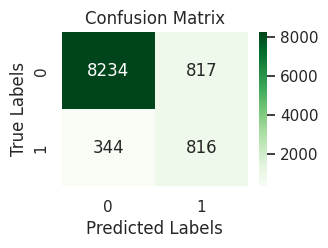

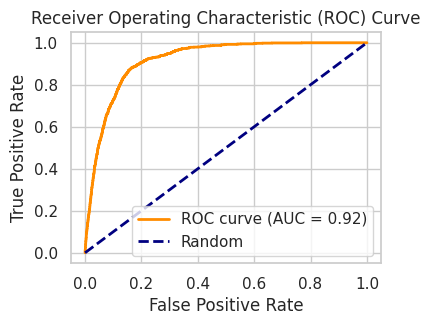


Run time for co-training (partition=0.5): 17.12688742876053 min.

----------------------------------


Partition Sample = 0.75

Labelled data instances:  (4073, 30)
Unlabelled data instances:  (12217, 30)
Precision: 0.49
Recall: 0.71
F1-score: 0.58
Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      9051
           1       0.49      0.71      0.58      1160

    accuracy                           0.88     10211
   macro avg       0.73      0.81      0.76     10211
weighted avg       0.91      0.88      0.89     10211



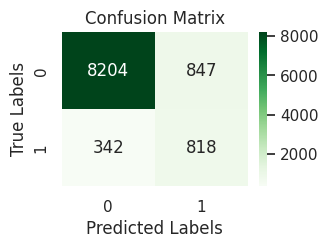

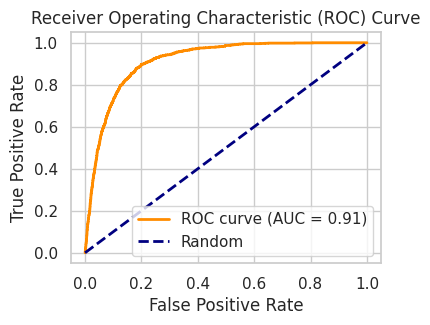


Run time for co-training (partition=0.75): 9.134973569711049 min.

----------------------------------


Partition Sample = 0.9

Labelled data instances:  (1629, 30)
Unlabelled data instances:  (14661, 30)
Precision: 0.47
Recall: 0.71
F1-score: 0.56
Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      9051
           1       0.47      0.71      0.56      1160

    accuracy                           0.88     10211
   macro avg       0.71      0.80      0.75     10211
weighted avg       0.90      0.88      0.89     10211



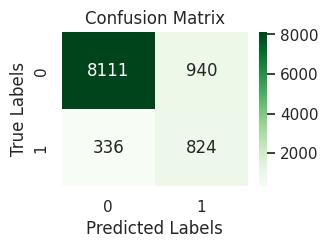

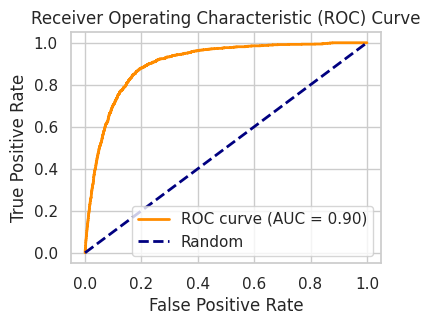


Run time for co-training (partition=0.9): 4.559491686026255 min.

----------------------------------


Partition Sample = 0.95

Labelled data instances:  (815, 30)
Unlabelled data instances:  (15475, 30)
Precision: 0.41
Recall: 0.73
F1-score: 0.52
Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      9051
           1       0.41      0.73      0.52      1160

    accuracy                           0.85     10211
   macro avg       0.68      0.80      0.72     10211
weighted avg       0.90      0.85      0.87     10211



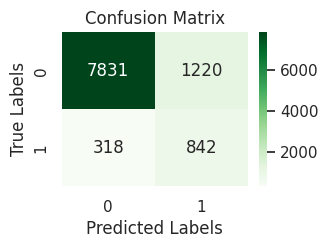

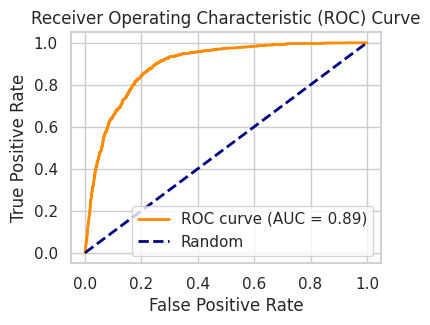


Run time for co-training (partition=0.95): 2.871679731210073 min.

----------------------------------


Partition Sample = 0.99

Labelled data instances:  (163, 30)
Unlabelled data instances:  (16127, 30)
Precision: 0.38
Recall: 0.68
F1-score: 0.49
Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90      9051
           1       0.38      0.68      0.49      1160

    accuracy                           0.84     10211
   macro avg       0.67      0.77      0.70     10211
weighted avg       0.89      0.84      0.86     10211



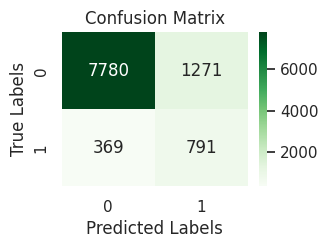

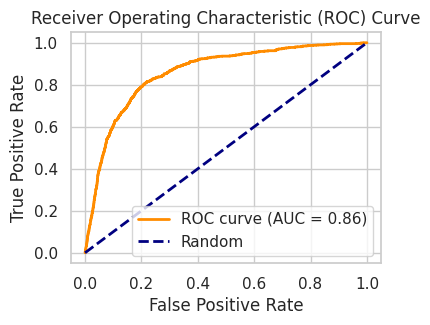


Run time for co-training (partition=0.99): 1.7277472654978434 min.

----------------------------------




In [ ]:
cotraining_evaluation(cotraining_algo1, X_train, y_train, X_test, y_test, unlabelled_partition_samples=[0.5, 0.75, 0.9, 0.95, 0.99])

Partition Sample = 0.9

Labelled data instances:  (3063, 30)
Unlabelled data instances:  (27567, 30)
Precision: 0.57
Recall: 0.40
F1-score: 0.47
Accuracy: 0.90

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      9051
           1       0.57      0.40      0.47      1160

    accuracy                           0.90     10211
   macro avg       0.75      0.68      0.71     10211
weighted avg       0.89      0.90      0.89     10211



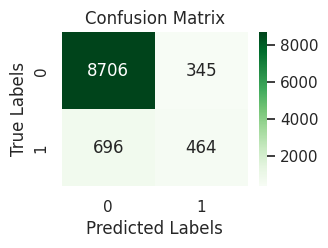

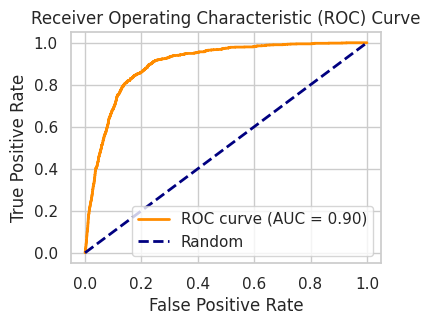


Run time for co-training (partition=0.9): 7.269216008981069 min.

----------------------------------




In [ ]:
cotraining_evaluation(cotraining_algo1, X_train_unsampled, y_train_unsampled, X_test, y_test, unlabelled_partition_samples=[0.9])

##### 3. semi-supervised ensemble

In [78]:
class BaggingEnsemble(BaseEstimator):
    def __init__(self, n_estimators=2):
        self.n_estimators = n_estimators
        self.estimators = [SelfTrainingClassifier(GradientBoostingClassifier(n_estimators=1000), threshold=0.85) for _ in range(self.n_estimators)]

    def fit(self, X_labeled, y_labeled, X_unlabeled):
        for estimator in self.estimators:
            # bootstrap sampling
            X_labeled_bootstrap, y_labeled_bootstrap = resample(X_labeled, y_labeled, replace=True)

            # add X and Y and fit it to the SelfTrainingClassifier model
            X_combined = np.vstack((X_labeled_bootstrap, X_unlabeled))
            y_combined = np.hstack((y_labeled_bootstrap, np.full((len(X_unlabeled),), -1)))

            estimator.fit(X_combined, y_combined)

    def predict(self, X):
        predictions = np.array([estimator.predict(X) for estimator in self.estimators])
        final_predictions, _ = mode(predictions, axis=0)
        return final_predictions

    def predict_proba(self, X):
        all_probabilities = [estimator.predict_proba(X) for estimator in self.estimators]
        avg_probabilities = np.mean(all_probabilities, axis=0)
        return avg_probabilities

In [84]:
def bagging_ensemble_evaluation(fun2, X_train, y_train, X_test, y_test, unlabelled_partition_samples=[0.5, 0.75, 0.9, 0.95, 0.99]):

  for partition in unlabelled_partition_samples:
    start = time.time()
    print(f"Partition Sample = {partition}\n")
    num_samples = int(partition * len(X_train))

    # Split the data into labelled and unlabelled using stratified sampling
    X_label, X_unlabel, y_label, y_unlabel = train_test_split(X_train, y_train, test_size=num_samples, stratify=y_train, random_state=42)

    print("Labelled data instances: ", X_label.shape)
    print("Unlabelled data instances: ", X_unlabel.shape)

    # Call fun2
    fun2(X_label, y_label, X_unlabel, X_test, y_test)
    end = time.time()
    print(f"\nRun time for bagging ensemble training (partition={partition}): {((end-start)/60)} min.")
    print("\n----------------------------------\n\n")

In [82]:
def bagging_ensemble(X_labeled, y_labeled, X_unlabeled, X_test, y_test):
  bagging_ensemble = BaggingEnsemble(n_estimators=2)
  bagging_ensemble.fit(X_labeled, y_labeled, X_unlabeled)
  y_pred = bagging_ensemble.predict(X_test)
  y_prob = bagging_ensemble.predict_proba(X_test)[:, 1]
  model_evaluation(y_test, y_pred)
  plot_confusion_matrix(y_test, y_pred)
  plot_roc_curve_prob(y_test, y_prob)

Partition Sample = 0.5

Labelled data instances:  (8145, 30)
Unlabelled data instances:  (8145, 30)
Precision: 0.53
Recall: 0.62
F1-score: 0.57
Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      9051
           1       0.53      0.62      0.57      1160

    accuracy                           0.89     10211
   macro avg       0.74      0.77      0.75     10211
weighted avg       0.90      0.89      0.90     10211



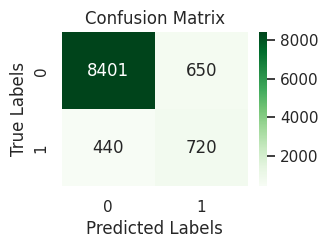

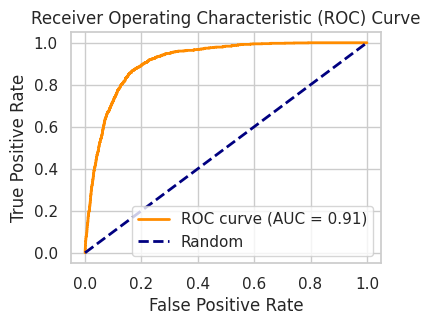


Run time for self training (partition=0.5): 12.108316266536713 min.

----------------------------------


Partition Sample = 0.75

Labelled data instances:  (4073, 30)
Unlabelled data instances:  (12217, 30)
Precision: 0.51
Recall: 0.67
F1-score: 0.58
Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      9051
           1       0.51      0.67      0.58      1160

    accuracy                           0.89     10211
   macro avg       0.73      0.79      0.76     10211
weighted avg       0.90      0.89      0.89     10211



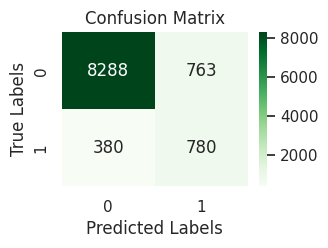

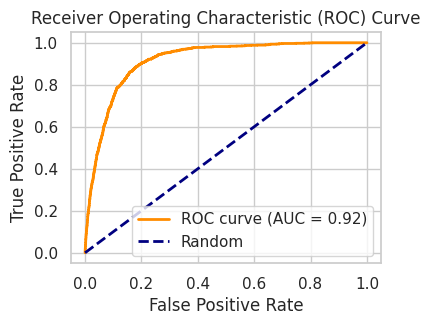


Run time for self training (partition=0.75): 10.894198699792225 min.

----------------------------------


Partition Sample = 0.9

Labelled data instances:  (1629, 30)
Unlabelled data instances:  (14661, 30)
Precision: 0.51
Recall: 0.60
F1-score: 0.55
Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      9051
           1       0.51      0.60      0.55      1160

    accuracy                           0.89     10211
   macro avg       0.73      0.76      0.74     10211
weighted avg       0.90      0.89      0.89     10211



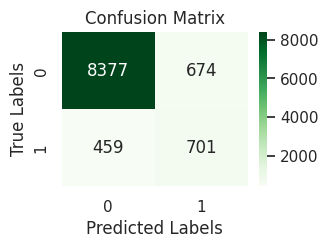

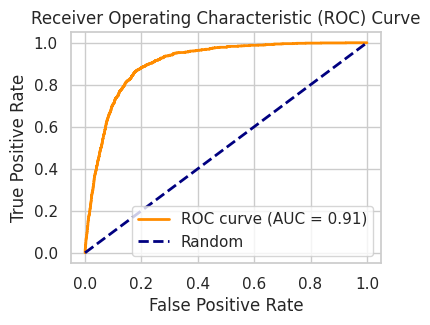


Run time for self training (partition=0.9): 11.191887843608857 min.

----------------------------------


Partition Sample = 0.95

Labelled data instances:  (815, 30)
Unlabelled data instances:  (15475, 30)
Precision: 0.45
Recall: 0.59
F1-score: 0.51
Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      9051
           1       0.45      0.59      0.51      1160

    accuracy                           0.87     10211
   macro avg       0.70      0.75      0.72     10211
weighted avg       0.89      0.87      0.88     10211



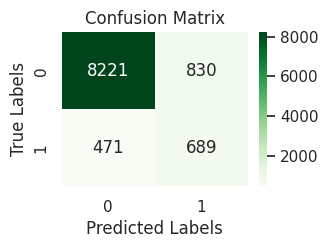

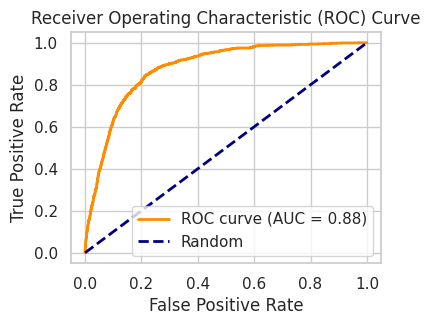


Run time for self training (partition=0.95): 11.099974497159321 min.

----------------------------------


Partition Sample = 0.99

Labelled data instances:  (163, 30)
Unlabelled data instances:  (16127, 30)
Precision: 0.42
Recall: 0.38
F1-score: 0.40
Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      9051
           1       0.42      0.38      0.40      1160

    accuracy                           0.87     10211
   macro avg       0.67      0.66      0.66     10211
weighted avg       0.86      0.87      0.87     10211



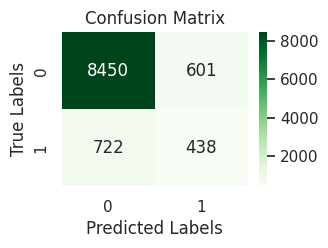

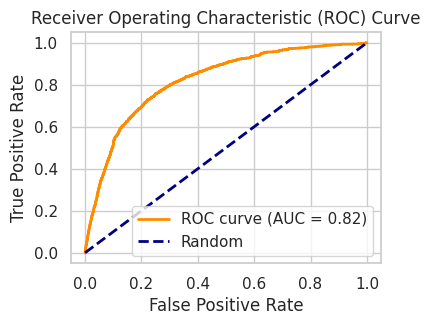


Run time for self training (partition=0.99): 11.399573338031768 min.

----------------------------------




In [86]:
bagging_ensemble_evaluation(bagging_ensemble, X_train, y_train, X_test, y_test)

Partition Sample = 0.9

Labelled data instances:  (3063, 30)
Unlabelled data instances:  (27567, 30)
Precision: 0.57
Recall: 0.25
F1-score: 0.35
Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      9051
           1       0.57      0.25      0.35      1160

    accuracy                           0.89     10211
   macro avg       0.74      0.61      0.65     10211
weighted avg       0.87      0.89      0.87     10211



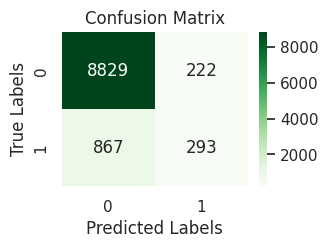

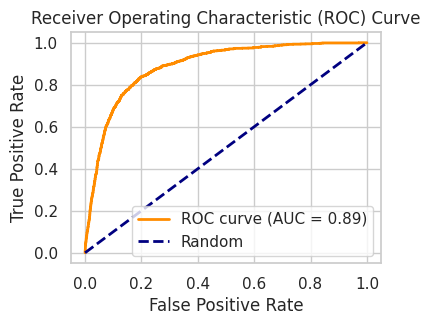


Run time for self training (partition=0.9): 20.6144961754481 min.

----------------------------------




In [87]:
bagging_ensemble_evaluation(bagging_ensemble, X_train_unsampled, y_train_unsampled, X_test, y_test, unlabelled_partition_samples=[0.9])

Following is a mean ensemble approach

In [ ]:
def label_prop(X_train_mixed, y_train_mixed, X_test, y_test):
  model = LabelPropagation()
  # fit model on training dataset
  model.fit(X_train_mixed, y_train_mixed)
  y_pred = model.predict(X_test)
  model_evaluation(y_test, y_pred)
  plot_confusion_matrix(y_test, y_pred)
  return y_pred

Precision: 0.34
Recall: 0.56
F1-score: 0.42
Accuracy: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90      9981
           1       0.34      0.56      0.42      1322

    accuracy                           0.82     11303
   macro avg       0.64      0.71      0.66     11303
weighted avg       0.87      0.82      0.84     11303



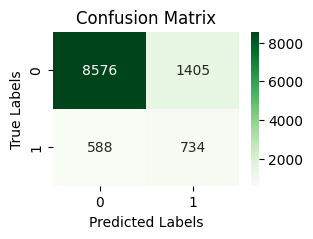

In [ ]:
lp_pred = label_prop(X_train_mixed, y_train_mixed, X_test, y_test)

In [ ]:
def semi_ensemble(st_pred, co_pred, lp_pred, y_test):
  # Ensemble prediction using averaging
  ensemble_probabilities = np.mean([st_pred, co_pred, lp_pred], axis=0)

  threshold = 0.5
  ensemble_predictions = (ensemble_probabilities >= threshold).astype(int)
  model_evaluation(y_test, ensemble_predictions)
  plot_confusion_matrix(y_test, ensemble_predictions)

Precision: 0.51
Recall: 0.72
F1-score: 0.60
Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      9981
           1       0.51      0.72      0.60      1322

    accuracy                           0.89     11303
   macro avg       0.73      0.81      0.76     11303
weighted avg       0.91      0.89      0.89     11303



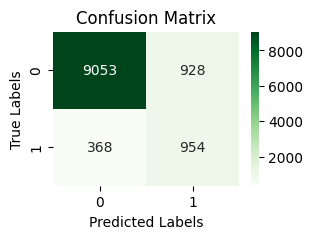

In [ ]:
semi_ensemble(st_pred, co_pred, lp_pred, y_test)

##### 4. approach that employs unsupervised pretraining

In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
  tsne = TSNE(n_components=2, random_state=0)
  X_t = tsne.fit_transform(x1)

  plt.figure(figsize=(12, 8))
  plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Not subscribed')
  plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Subscribed')

  plt.legend(loc='best')
  plt.savefig(name)
  plt.show()

In [ ]:
def prep_tsne_data(X, y, y0_sample=1000, y1_sample=500):
  df_temp = X.copy()
  df_temp['y'] = y
  y0 = df_temp[df_temp['y'] == 0].sample(y0_sample)
  y1 = df_temp[df_temp['y'] == 1].sample(y1_sample)

  df_temp = y0.append(y1).sample(frac=1).reset_index(drop=True)
  X_tsne = df_temp.drop(['y'], axis = 1).values
  Y_tsne = df_temp['y'].values
  return X_tsne, Y_tsne

In [ ]:
def autoencoder_model():
  ## input layer
  input_layer = Input(shape=(X.shape[1],))

  ## encoding part
  encoded = Dense(720, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
  encoded = Dense(480, activation='relu')(encoded)
  encoded = Dense(360, activation='relu')(encoded)
  encoded = Dense(240, activation='relu')(encoded)
  encoded = Dense(144, activation='relu')(encoded)

  ## decoding part
  decoded = Dense(144, activation='relu')(encoded)
  decoded = Dense(240, activation='relu')(decoded)
  decoded = Dense(360, activation='relu')(decoded)
  decoded = Dense(480, activation='relu')(decoded)
  decoded = Dense(720, activation='relu')(decoded)

  ## output layer
  output_layer = Dense(X.shape[1], activation='relu')(decoded)

  autoencoder = Model(input_layer, output_layer)
  autoencoder.compile(optimizer="adadelta", loss="mse")
  return autoencoder

In [ ]:
def unsup_pretraining_evaluation(partition, X_train, y_train, X_test, y_test):
  start = time.time()
  print(f"Partition Sample = {partition}\n")
  num_samples = int(partition * len(X_train))

  # Split the data into labelled and unlabelled using stratified sampling
  X_label, X_unlabel, y_label, y_unlabel = train_test_split(X_train, y_train, test_size=num_samples, stratify=y_train, random_state=42)

  print("Labelled data instances: ", X_label.shape)
  print("Unlabelled data instances: ", X_unlabel.shape)

  y_temp = y_unlabel.values
  x_not_subscribed, x_subscribed = X_unlabel[y_temp == 0], X_unlabel[y_temp == 1]

  print("\nSubscribed data instances: ", x_subscribed.shape)
  print("Not subscribed data instances: ", x_not_subscribed.shape)

  autoencoder = autoencoder_model()
  autoencoder.fit(x_not_subscribed[0:len(x_not_subscribed)-1], x_not_subscribed[0:len(x_not_subscribed)-1],
                batch_size = 256, epochs = 100,
                shuffle = True, validation_split = 0.20)

  hidden_representation = Sequential([
      Dense(720, activation='relu', activity_regularizer=regularizers.l1(10e-5)),
      Dense(480, activation='relu'),
      Dense(360, activation='relu'),
      Dense(240, activation='relu'),
      Dense(144, activation='relu')
  ])

  ## train data
  not_subs_hid_rep = hidden_representation.predict(x_not_subscribed)
  subs_hid_rep = hidden_representation.predict(x_subscribed)

  rep_train_x = np.append(not_subs_hid_rep, subs_hid_rep, axis = 0)
  y_n = np.zeros(not_subs_hid_rep.shape[0])
  y_f = np.ones(subs_hid_rep.shape[0])
  rep_train_y = np.append(y_n, y_f)
  clf = GradientBoostingClassifier(n_estimators=550).fit(rep_train_x, rep_train_y)

  ## test data
  y_temp = y_test.values
  x_not_subscribed, x_subscribed = X_test[y_temp == 0], X_test[y_temp == 1]
  not_subs_hid_rep = hidden_representation.predict(x_not_subscribed)
  subs_hid_rep = hidden_representation.predict(x_subscribed)

  rep_test_x = np.append(not_subs_hid_rep, subs_hid_rep, axis = 0)
  y_n = np.zeros(not_subs_hid_rep.shape[0])
  y_f = np.ones(subs_hid_rep.shape[0])
  rep_test_y = np.append(y_n, y_f)

  ## prediction
  y_pred = clf.predict(rep_test_x)
  y_prob = clf.predict_proba(rep_test_x)[:, 1]
  model_evaluation(rep_test_y, y_pred)
  plot_confusion_matrix(rep_test_y, y_pred)
  plot_roc_curve_prob(rep_test_y, y_prob)
  end = time.time()
  print(f"\nRun time for unsupervised pretraining (using autoencoders) (partition={partition}): {((end-start)/60)} min.")
  print("\n----------------------------------\n\n")

In [ ]:
X_tsne, Y_tsne = prep_tsne_data(X_train, y_train.values)

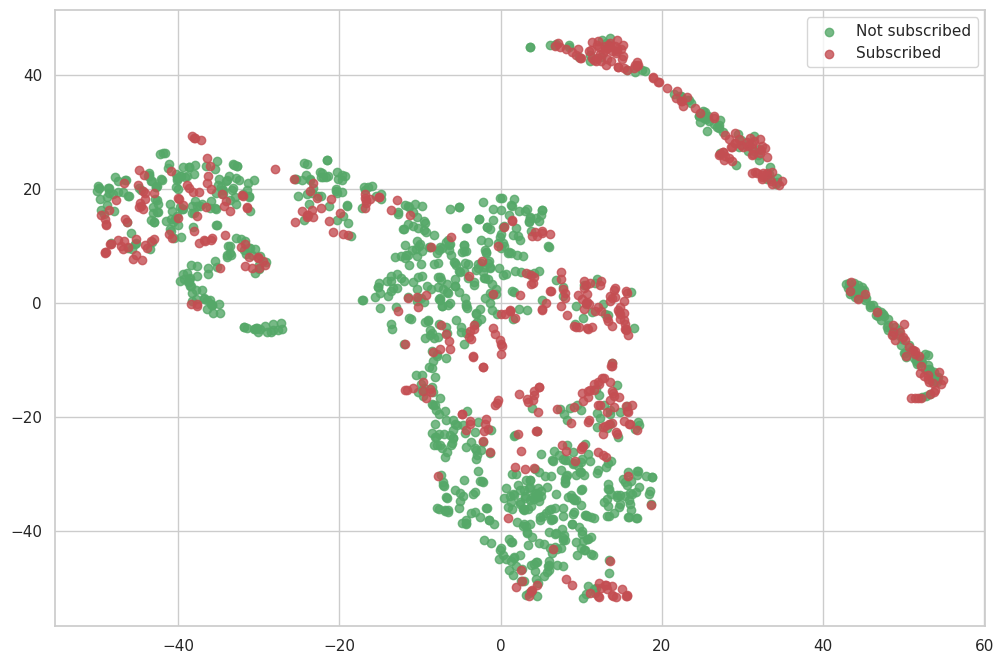

In [ ]:
tsne_plot(X_tsne, Y_tsne, "original.png")

Partition Sample = 0.5

Labelled data instances:  (8145, 30)
Unlabelled data instances:  (8145, 30)

Subscribed data instances:  (2715, 30)
Not subscribed data instances:  (5430, 30)
Epoch 1/100
17/17 [==============================] - 8s 155ms/step - loss: 321.7365 - val_loss: 324.6175
Epoch 2/100
17/17 [==============================] - 2s 124ms/step - loss: 321.7310 - val_loss: 324.6136
Epoch 3/100
17/17 [==============================] - 2s 118ms/step - loss: 321.7267 - val_loss: 324.6101
Epoch 4/100
17/17 [==============================] - 2s 143ms/step - loss: 321.7229 - val_loss: 324.6072
Epoch 5/100
17/17 [==============================] - 3s 160ms/step - loss: 321.7196 - val_loss: 324.6046
Epoch 6/100
17/17 [==============================] - 2s 115ms/step - loss: 321.7164 - val_loss: 324.6021
Epoch 7/100
17/17 [==============================] - 2s 110ms/step - loss: 321.7138 - val_loss: 324.6001
Epoch 8/100
17/17 [==============================] - 2s 115ms/step - loss: 321.711

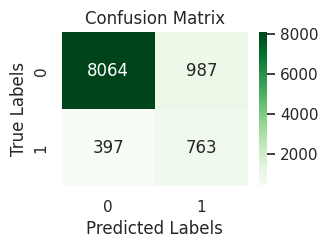

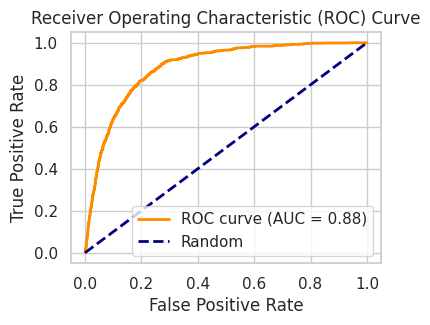


Run time for unsupervised pretraining (using autoencoders) (partition=0.5): 6.172700162728628 min.

----------------------------------




In [ ]:
unsup_pretraining_evaluation(0.5, X_train, y_train, X_test, y_test)

Partition Sample = 0.75

Labelled data instances:  (4073, 30)
Unlabelled data instances:  (12217, 30)

Subscribed data instances:  (4072, 30)
Not subscribed data instances:  (8145, 30)
Epoch 1/100
26/26 [==============================] - 6s 101ms/step - loss: 300.1494 - val_loss: 335.4122
Epoch 2/100
26/26 [==============================] - 2s 69ms/step - loss: 298.8868 - val_loss: 333.7567
Epoch 3/100
26/26 [==============================] - 2s 69ms/step - loss: 297.1413 - val_loss: 331.5586
Epoch 4/100
26/26 [==============================] - 3s 111ms/step - loss: 294.9628 - val_loss: 328.7006
Epoch 5/100
26/26 [==============================] - 2s 91ms/step - loss: 291.8978 - val_loss: 324.4522
Epoch 6/100
26/26 [==============================] - 2s 69ms/step - loss: 286.8019 - val_loss: 316.5269
Epoch 7/100
26/26 [==============================] - 2s 68ms/step - loss: 276.7393 - val_loss: 299.7515
Epoch 8/100
26/26 [==============================] - 2s 67ms/step - loss: 251.4456 - 

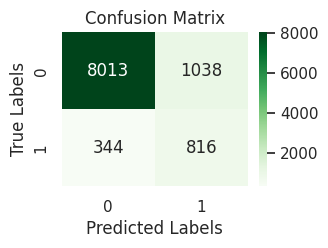

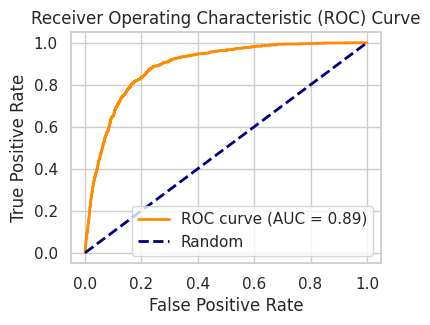


Run time for unsupervised pretraining (using autoencoders) (partition=0.75): 7.233953694502513 min.

----------------------------------




In [ ]:
unsup_pretraining_evaluation(0.75, X_train, y_train, X_test, y_test)

Partition Sample = 0.9

Labelled data instances:  (1629, 30)
Unlabelled data instances:  (14661, 30)

Subscribed data instances:  (4887, 30)
Not subscribed data instances:  (9774, 30)
Epoch 1/100
31/31 [==============================] - 4s 65ms/step - loss: 294.3836 - val_loss: 324.2972
Epoch 2/100
31/31 [==============================] - 2s 57ms/step - loss: 292.4859 - val_loss: 321.7515
Epoch 3/100
31/31 [==============================] - 2s 57ms/step - loss: 289.5756 - val_loss: 317.3534
Epoch 4/100
31/31 [==============================] - 3s 82ms/step - loss: 283.6958 - val_loss: 307.6674
Epoch 5/100
31/31 [==============================] - 3s 83ms/step - loss: 267.8892 - val_loss: 275.1320
Epoch 6/100
31/31 [==============================] - 2s 57ms/step - loss: 194.6246 - val_loss: 87.3775
Epoch 7/100
31/31 [==============================] - 2s 58ms/step - loss: 14.1286 - val_loss: 1.9080
Epoch 8/100
31/31 [==============================] - 2s 57ms/step - loss: 1.8967 - val_loss:

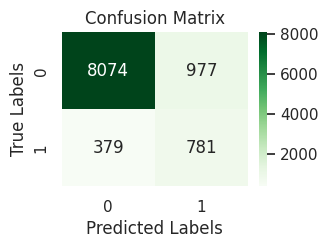

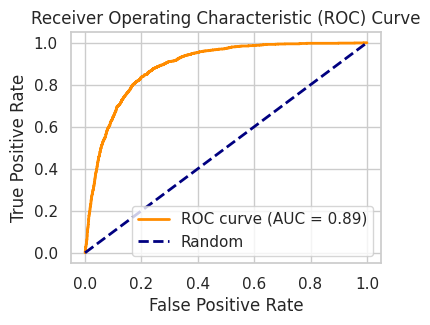


Run time for unsupervised pretraining (using autoencoders) (partition=0.9): 8.251765823364257 min.

----------------------------------




In [ ]:
unsup_pretraining_evaluation(0.9, X_train, y_train, X_test, y_test)

Partition Sample = 0.95

Labelled data instances:  (815, 30)
Unlabelled data instances:  (15475, 30)

Subscribed data instances:  (5158, 30)
Not subscribed data instances:  (10317, 30)
Epoch 1/100
33/33 [==============================] - 4s 66ms/step - loss: 303.8434 - val_loss: 273.2042
Epoch 2/100
33/33 [==============================] - 2s 57ms/step - loss: 302.2192 - val_loss: 271.4933
Epoch 3/100
33/33 [==============================] - 2s 59ms/step - loss: 299.9138 - val_loss: 268.7868
Epoch 4/100
33/33 [==============================] - 2s 59ms/step - loss: 295.5741 - val_loss: 263.1706
Epoch 5/100
33/33 [==============================] - 3s 86ms/step - loss: 286.0964 - val_loss: 249.8673
Epoch 6/100
33/33 [==============================] - 3s 76ms/step - loss: 257.0330 - val_loss: 193.9299
Epoch 7/100
33/33 [==============================] - 2s 58ms/step - loss: 100.7774 - val_loss: 2.2974
Epoch 8/100
33/33 [==============================] - 2s 58ms/step - loss: 2.1457 - val_lo

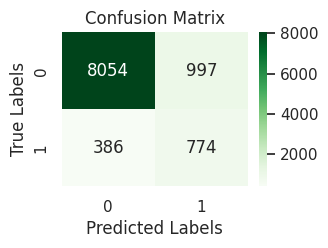

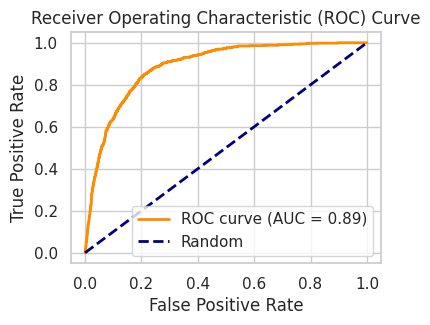


Run time for unsupervised pretraining (using autoencoders) (partition=0.95): 9.769979445139567 min.

----------------------------------




In [ ]:
unsup_pretraining_evaluation(0.95, X_train, y_train, X_test, y_test)

Partition Sample = 0.99

Labelled data instances:  (163, 30)
Unlabelled data instances:  (16127, 30)

Subscribed data instances:  (5376, 30)
Not subscribed data instances:  (10751, 30)
Epoch 1/100
34/34 [==============================] - 5s 92ms/step - loss: 295.0691 - val_loss: 307.2255
Epoch 2/100
34/34 [==============================] - 2s 58ms/step - loss: 295.0460 - val_loss: 307.2030
Epoch 3/100
34/34 [==============================] - 2s 59ms/step - loss: 295.0265 - val_loss: 307.1846
Epoch 4/100
34/34 [==============================] - 2s 59ms/step - loss: 295.0089 - val_loss: 307.1670
Epoch 5/100
34/34 [==============================] - 2s 58ms/step - loss: 294.9924 - val_loss: 307.1513
Epoch 6/100
34/34 [==============================] - 3s 76ms/step - loss: 294.9779 - val_loss: 307.1372
Epoch 7/100
34/34 [==============================] - 3s 85ms/step - loss: 294.9647 - val_loss: 307.1249
Epoch 8/100
34/34 [==============================] - 2s 58ms/step - loss: 294.9533 - va

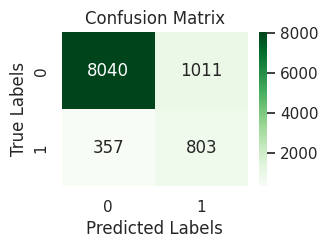

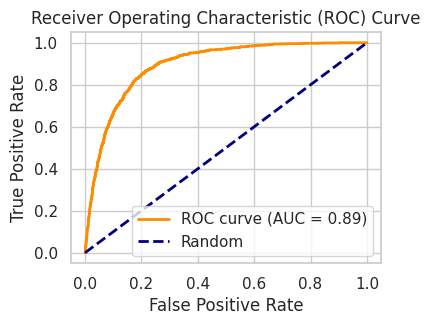


Run time for unsupervised pretraining (using autoencoders) (partition=0.99): 10.300458761056264 min.

----------------------------------




In [ ]:
unsup_pretraining_evaluation(0.99, X_train, y_train, X_test, y_test)

Partition Sample = 0.9

Labelled data instances:  (3063, 30)
Unlabelled data instances:  (27567, 30)

Subscribed data instances:  (3131, 30)
Not subscribed data instances:  (24436, 30)
Epoch 1/100
77/77 [==============================] - 7s 61ms/step - loss: 289.6500 - val_loss: 285.1457
Epoch 2/100
77/77 [==============================] - 4s 58ms/step - loss: 282.0034 - val_loss: 269.6016
Epoch 3/100
77/77 [==============================] - 6s 76ms/step - loss: 183.1501 - val_loss: 2.2300
Epoch 4/100
77/77 [==============================] - 4s 56ms/step - loss: 2.0646 - val_loss: 2.0479
Epoch 5/100
77/77 [==============================] - 5s 61ms/step - loss: 1.9948 - val_loss: 1.9967
Epoch 6/100
77/77 [==============================] - 7s 94ms/step - loss: 1.9535 - val_loss: 1.9644
Epoch 7/100
77/77 [==============================] - 4s 56ms/step - loss: 1.9273 - val_loss: 1.9437
Epoch 8/100
77/77 [==============================] - 5s 61ms/step - loss: 1.9099 - val_loss: 1.9297
Epoch

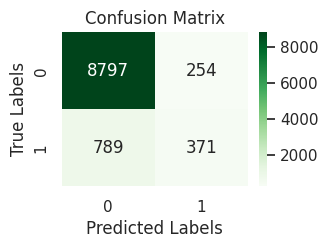

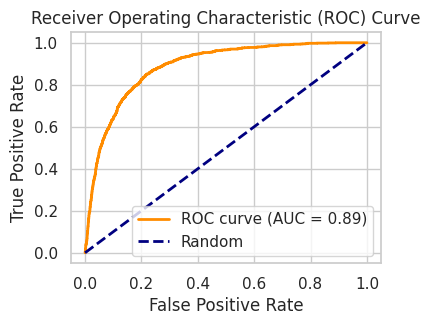


Run time for unsupervised pretraining (using autoencoders) (partition=0.9): 19.44085148572922 min.

----------------------------------




In [ ]:
unsup_pretraining_evaluation(0.9, X_train_unsampled, y_train_unsampled, X_test, y_test)

#### Statistical Test

In [97]:
f1_scores = {
    'Self-Training': [0.59, 0.58, 0.56, 0.53, 0.49],
    'Co-Training': [0.58, 0.58, 0.56, 0.52, 0.49],
    'Semi-Supervised Ensemble': [0.57, 0.58, 0.55, 0.51, 0.40],
    'Unsupervised Pretraining': [0.52, 0.54, 0.54, 0.53, 0.54]
}

# Perform paired t-tests for all pairs of algorithms
alpha = 0.05  # Significance level
isSignifcant = False
for alg1, alg2 in combinations(f1_scores.keys(), 2):
    t_stat, p_val = stats.ttest_rel(f1_scores[alg1], f1_scores[alg2])
    print("p-val: ", p_val)
    if p_val < alpha:
        isSignificant = True
        print(f"Statistically significant difference between {alg1} and {alg2}")

if not isSignifcant:
  print("\nNo significant difference")

p-val:  0.1778078083562211
p-val:  0.15377650690000996
p-val:  0.4716055293587758
p-val:  0.22206822756388334
p-val:  0.5685308030245338
p-val:  0.7438341267322647

No significant difference
